# Exploratory Analysis

### Contents

- [Exploratory Analysis](#6)
	- [Taking a look at things](#7)
	- [Principal Component Analysis](#8)
	- [Clustering](#9)
	- [Network Analysis](#10)

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scikitplot as skplt
from matplotlib.colors import ListedColormap

#clustering & network
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from itertools import combinations
import networkx as nx
import operator

In [17]:
df7 = pd.read_csv('../df7.csv')
binary_cols = pd.read_csv('../binary_cols.csv')
df7 = df7.drop(columns='Unnamed: 0')

Records >£100= 203


array([[<AxesSubplot:title={'center':'pound_value'}>]], dtype=object)

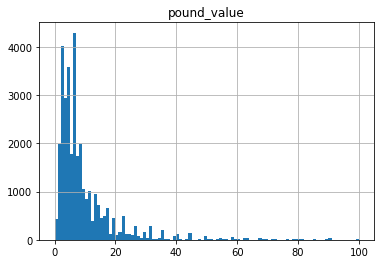

In [18]:
# ~ 2/3 of records are under £10
over100 = df7[df7['pound_value']>100]
under100 = df7[df7['pound_value']<100]
              
print('Records >£100=',len(over100))
under100.hist(column='pound_value',bins=100)

array([[<AxesSubplot:title={'center':'rated'}>]], dtype=object)

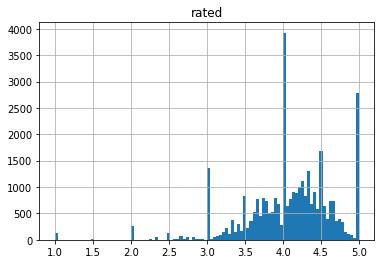

In [19]:
#most records have between 3 and 5 stars
df7.hist(column='rated',bins=100)

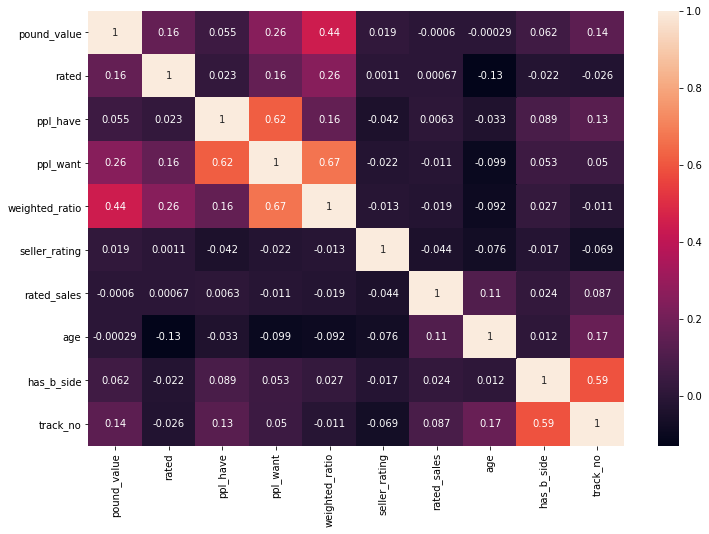

In [20]:
df7['age'] = df7['year'].map(lambda x: int(2019 - x))

ratio_w = []
for record in zip(df7.ppl_want, df7.ppl_have):
    try:
        ratio_w.append(round(np.sqrt(record[0]**2/record[1]),2))
    except:
        ratio_w.append(np.nan)

df7['weighted_ratio'] = ratio_w       

numeric = ['pound_value','rated','ppl_have','ppl_want','weighted_ratio'
          ,'seller_rating','rated_sales','age','has_b_side','track_no']

#also seeing correlations between b-side & track no, age & track no
plt.figure(figsize=(12,8))
sns.heatmap(df7[numeric].corr(),annot=True)
plt.show()

array([[<AxesSubplot:title={'center':'weighted_ratio'}>]], dtype=object)

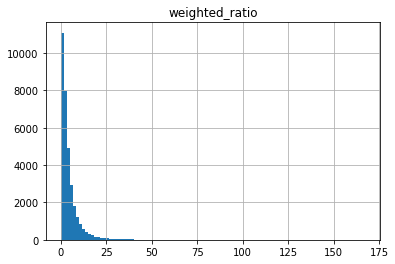

In [26]:
#most ratios are close to 0, would regard anything higher than 25 as a very high ratio
df7.hist(column='weighted_ratio', bins=100)

In [27]:
#expensive records have high ratios
df7.sort_values(by='pound_value', ascending=False).head(10)[['pound_value','artist','album','weighted_ratio']]

,pound_value,artist,album,weighted_ratio
33,801.00,David Bowie,The Man Who Sold The World,72.56
17211,750.00,Frank Ocean,Blond,70.89
46,720.00,Cizinha,Prá Fazer Um Samba / Pastorinhas,24.00
6423,719.96,Briard,I Really Hate Ya / I Want Ya Back,20.00
6734,630.00,David Bowie,David Bowie,89.37
6903,630.00,Harrison Jones & The Voices Of Harmony,The Power Of The Lord,90.07
18517,562.50,Athenians Of Toronto,Σαν Σκοτεινιάζει,12.91
30199,552.99,Minority Band,Journey To The Shore,167.38
31658,499.99,John Mayall And Eric Clapton,Lonely Years,13.86
6864,495.00,Heaven's Sound,Heaven's Sound,34.06


vinyl_condition


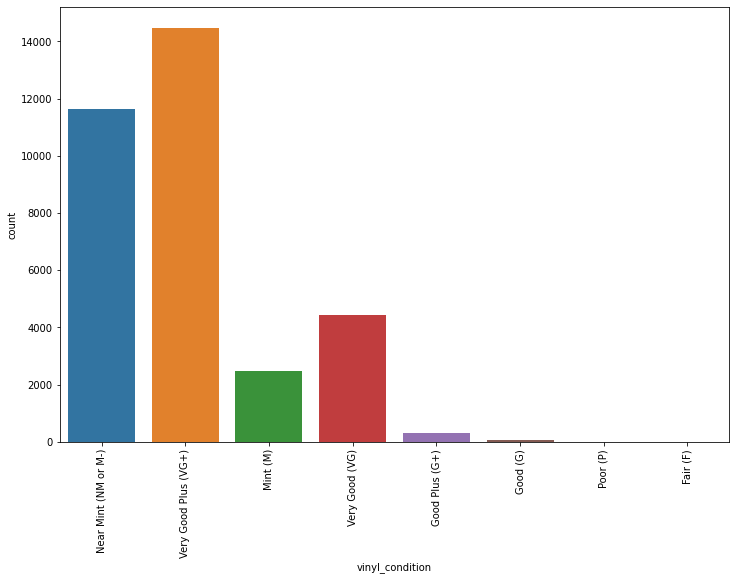

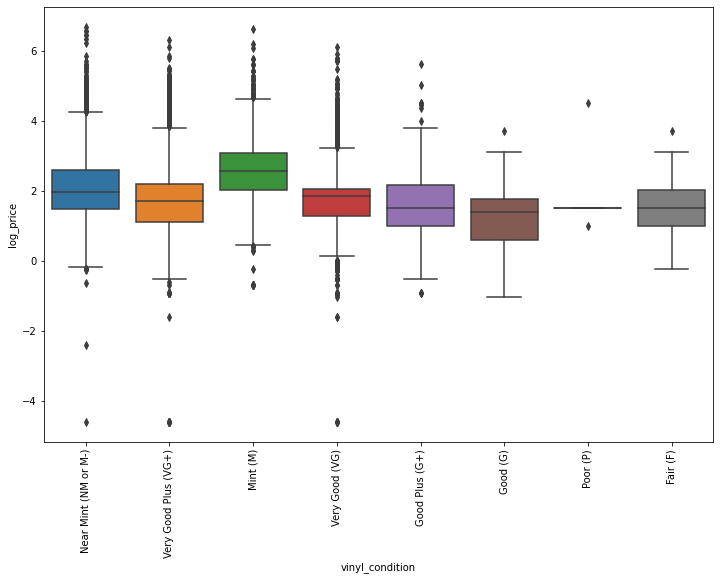

sleeve_condition


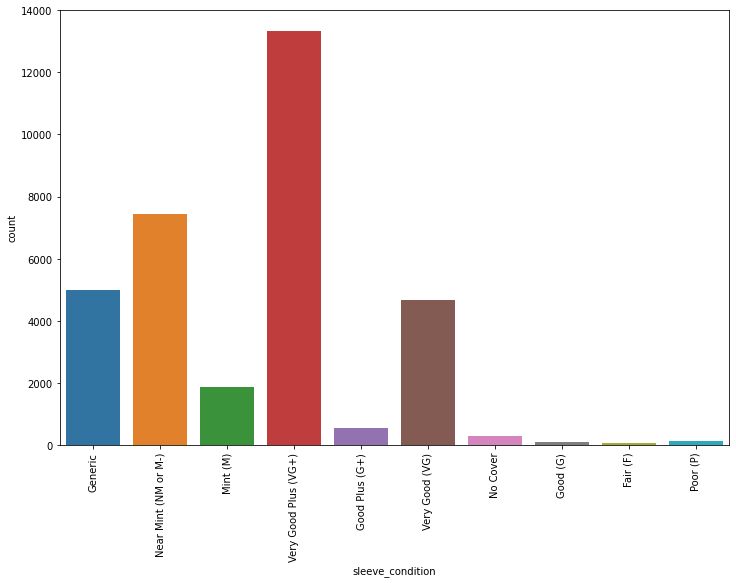

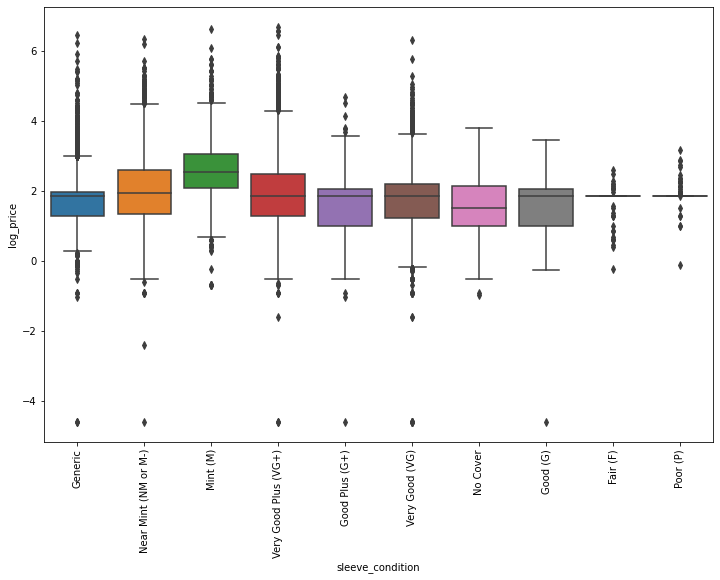

ships_from


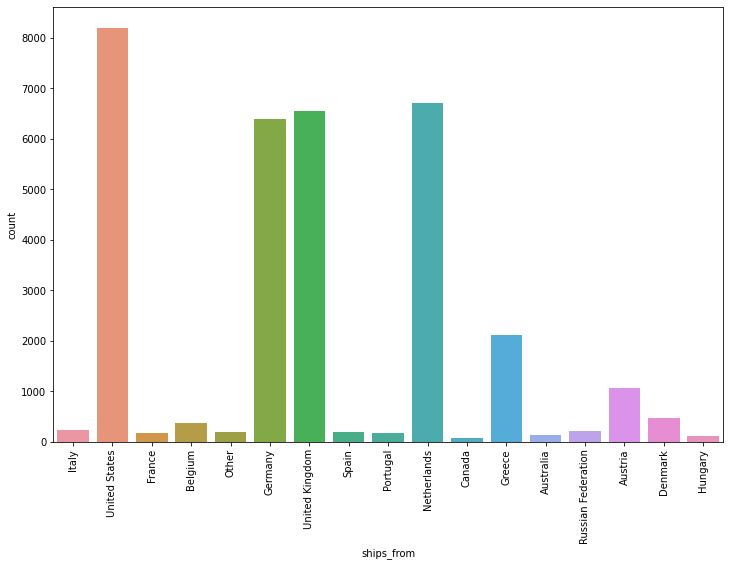

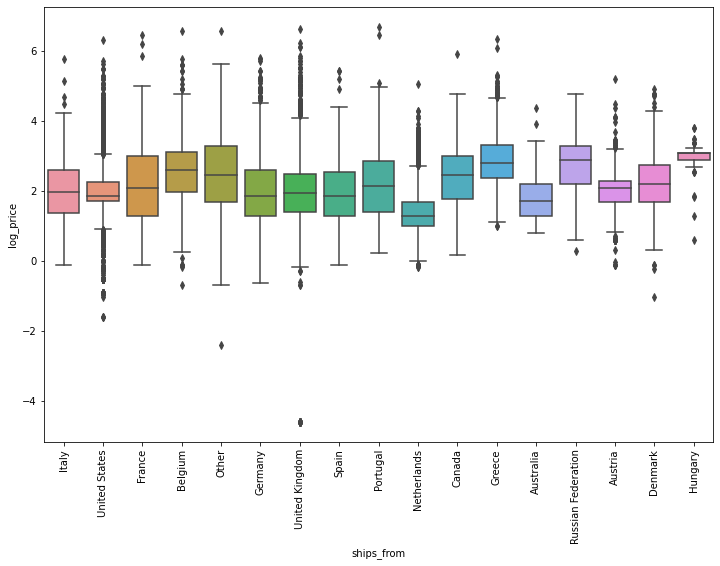

country_origin


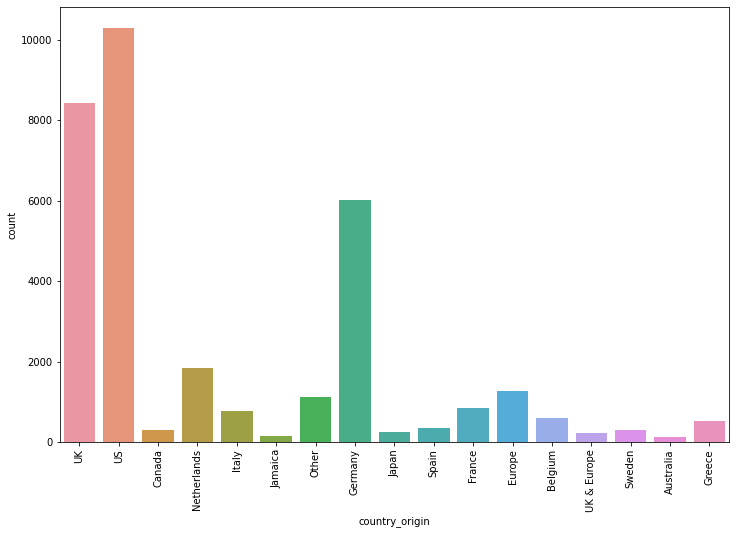

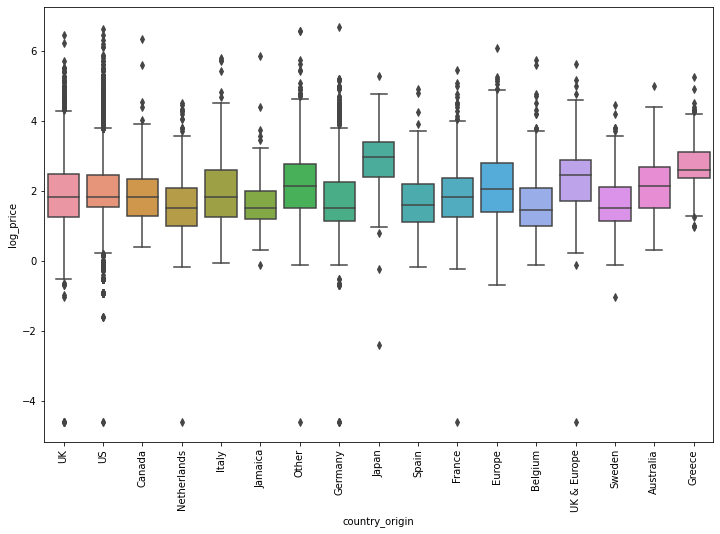

has_b_side


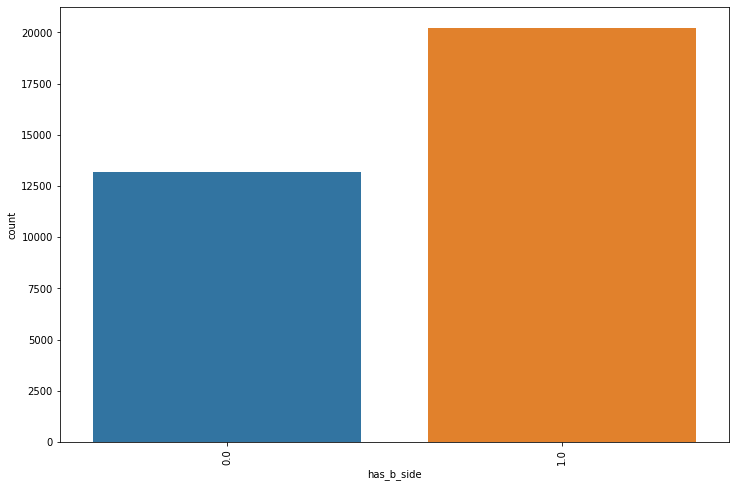

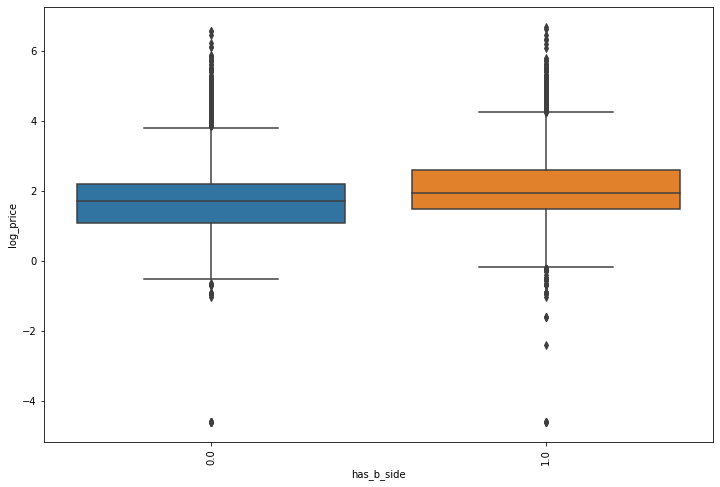

Electronic


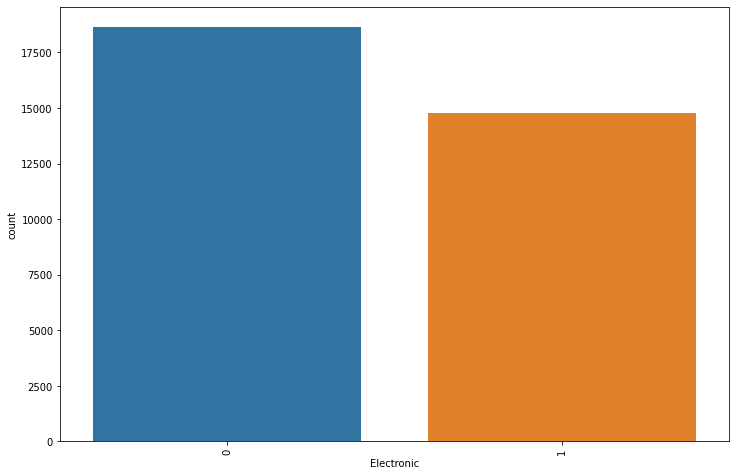

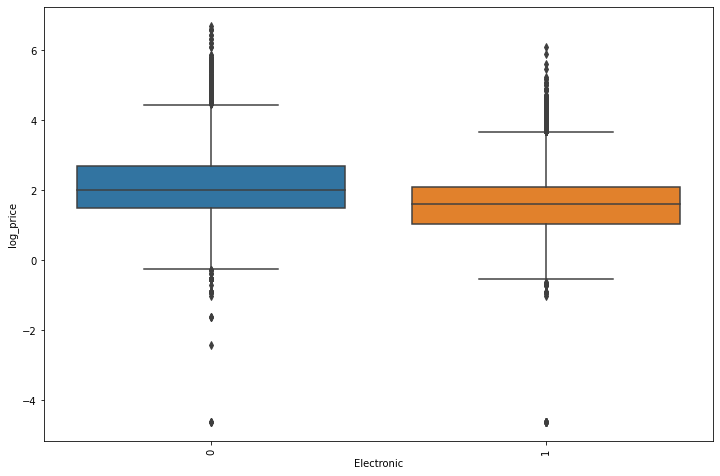

age


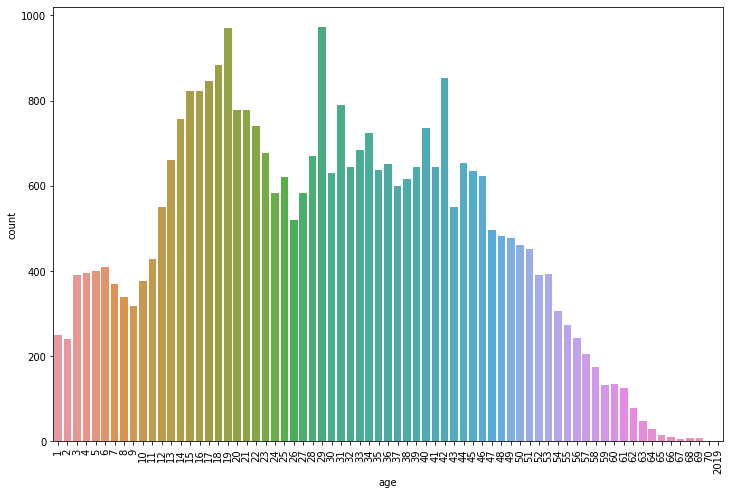

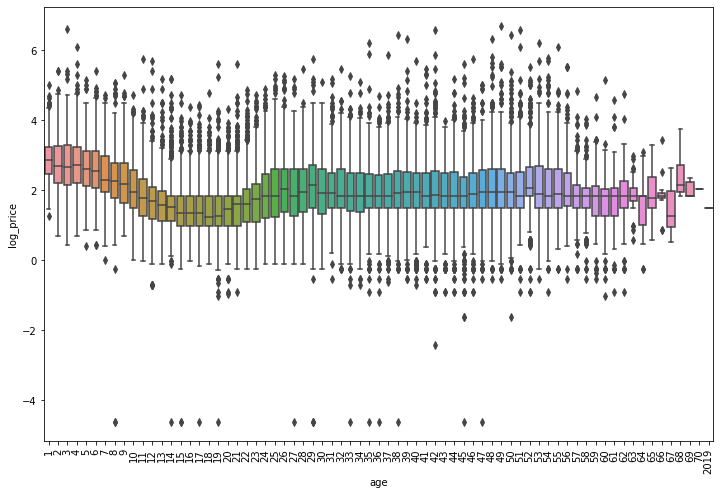

In [29]:
#i just want to see the top 17 countries for origin and exporting, categorising the rest as other

ship_countries = list(pd.DataFrame(df7.ships_from.value_counts().reset_index()).head(17)['index'])
origin_countries = list(pd.DataFrame(df7.country_origin.value_counts().reset_index()).head(17)['index'])

df7['ships_from'] = [x if x in ship_countries else 'Other' for x in df7.ships_from]
df7['country_origin'] = [x if x in origin_countries else 'Other' for x in df7.country_origin]

cats = ['vinyl_condition','sleeve_condition','ships_from','country_origin','has_b_side','Electronic','age']

df7['log_price'] = [np.log(x) for x in df7.pound_value]

def plot_function(var):
    plt.figure(figsize=(12,8))
    ax = sns.countplot(data=df7, x=var)
    plt.xticks(rotation=90)
    plt.show()
    return ax

def plot_function2(var,target='pound_value'):
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(data=df7, x=var, y=target)
    plt.xticks(rotation=90)
    plt.show()
    return ax

for i in cats:
    print(i)
    plot_function(i)
    plot_function2(i,'log_price')
    

## Engineering a Variable For Genres & Styles

I tried putting all the previous variables plus genre (12 genres in total) into a simple regression model, and found that rock & electronic had a place in the model. I then tried using sub-genres (400+ styles), which gave me a weaker model and no coefficients.

Rock and electronic are very broad categories, so I'm creating clusters to divide the 2, and hopefully generate something more useful in the model.

<a id="8"></a>
<a id="9"></a>
### PCA & K-mean Clusters

In [36]:
#Reducing a binary matrix of style, label, age & country of origin to 3 columns

#Adding Label and age to the Binarized mix
test = pd.get_dummies(df7[['label','age','country_origin']],
                      columns=['label','age','country_origin'])

style_list = binary_cols.columns[19:]

matrix1 = binary_cols[style_list].join(test)

scaler = StandardScaler()
matrix2 = pd.DataFrame(scaler.fit_transform(matrix1), columns=matrix1.columns)

Explained variance: [0.447 0.286 0.214]
       PC_1      PC_2      PC_3
0 -0.201425 -0.309201 -0.636123
1  0.515373  0.946104 -0.215272
2  0.237168 -0.074078  0.183622
3 -0.140023 -0.417182  0.136486
4  0.536486 -1.008413 -0.593500


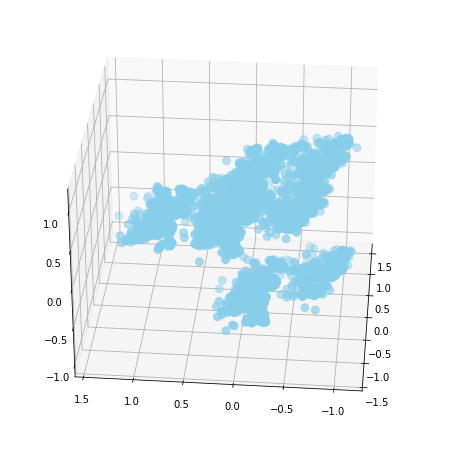

In [37]:
# Several clusters can clearly be seen in the graph below, but 2 of them are just mega rock & electronic clusters, and
# were the only 2 clusters significant in the model. 

pca = PCA(n_components=3)
cols = ['PC_{}'.format(i) for i in range(1,pca.n_components+1)]

X_pca_3 = pd.DataFrame(pca.fit_transform(matrix1), columns=cols)

print("Explained variance:", np.round(pca.explained_variance_, 3))
print(X_pca_3.head())

kmeans = KMeans(n_clusters=15)
clusters = kmeans.fit_predict(X_pca_3)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3['PC_1'], X_pca_3['PC_2'], X_pca_3['PC_3'],c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()

Explained variance: [5.451 4.602 4.233 3.775 3.598]
       PC_1      PC_2      PC_3      PC_4       PC_5
0 -1.160163  0.312964  0.010771  0.285817  10.963234
1  0.956735 -0.178614 -1.277076  2.937943   0.494358
2  0.571899 -0.322352 -0.413566  0.469393  -0.113791
3 -0.816526 -0.407872 -0.908607 -2.539278  -0.519317
4  1.299830 -0.845552 -2.132404 -1.292809  -0.128799


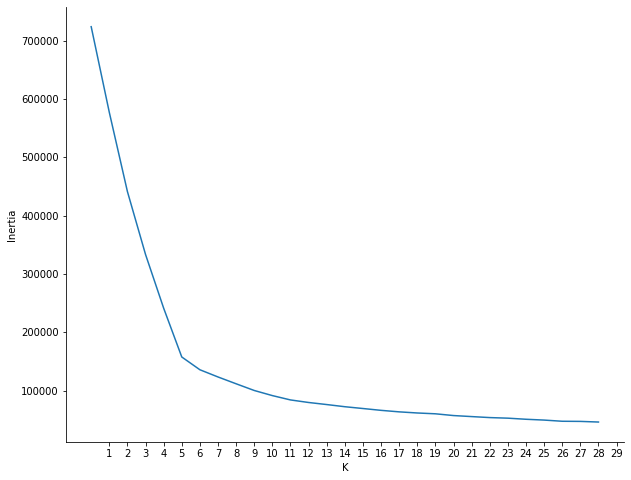

In [39]:
# Now trying 5 principal components. The elbow plot shows diminishing inertia scores after just a few clusters
# This means theres not a lot of difference seperating the data, but there is definitely difference in the music within clusters.

pca = PCA(n_components=5)
cols = ['PC_{}'.format(i) for i in range(1,pca.n_components+1)]

#this is working better on non-standardized data
X_pca_5 = pd.DataFrame(pca.fit_transform(matrix2),columns=cols)

print("Explained variance:", np.round(pca.explained_variance_, 3))
print(X_pca_5.head())

inertias = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_pca_5)
    inertia = kmeans.inertia_
    inertias.append(inertia)

plt.figure(figsize=(10, 8))
plt.plot(inertias)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.xticks(range(1,30))
sns.despine()

<a id="10"></a>
### Network Analysis 

Clustering offered no improvement on just using genre in the model, as the 2 main clusters are still just proxies for Rock & Electronic.
I'll hopefully be able to unravel those 2 groups a bit more by looking at networks of sub-genres within them.

Given the nature of the data I scraped (styles were lists of several rather than just 1 style), I'm going to create a flat list of all the tuple pairings per album then analyse the data on a different level to everything before. 

In [40]:
#top sub-genres per genre

Electronic = ['House','Techno','DrumnBass','Disco','Synth-pop','TechHouse','DeepHouse','Electro','Trance','Minimal',
           'Experimental','NewWave','ProgressiveHouse','Downtempo','Breakbeat','GarageHouse','RnB/Swing',
           'ProgressiveTrance','Ambient','Dub','Breaks','Jungle','Acid','HardHouse','HardTrance','EuroHouse',
            'Tribal','Swing','TribalHouse','Dubstep','UKGarage','Hip-House','Europop','HiNRG','BassMusic',
            'Industrial','Gabber']

Rock = ['PopRock','Punk','PsychedelicRock','Hardcore','AlternativeRock','ClassicRock','Rock&Roll','IndieRock',
      'FolkRock','Country','HardRock','ProgRock','BluesRock','Rhythm&Blues','EasyListening','Folk','GarageRock',
      'Ballad','Soundtrack','SoftRock','HeavyMetal','CountryRock','Fusion','ArtRock','Jazz-Rock','Thrash','Acoustic',
      'Thrash','StonerRock','Glam','Noise','Krautrock','Leftfield','DeathMetal','GothRock','Modern'
      ,'Rockabilly','SpaceRock','DoomMetal','SymphonicRock','BlackMetal','Surf','Lo-Fi','SouthernRock'
      ,'Ska','PostRock','Grunge','ArenaRock','Mod','Shoegaze','ElectricBlues']

In [41]:
# plotting a network diagram of all the connetions between sub-genres, then removing the most divisive links, to 
# hopefully unearth distinct communities within the mega-rock and electronic sectors.

def network_function(rock_or_electronic):
    
    nodes_to_use=rock_or_electronic
    
    #only want records where 2+ of the styles are in the list
    usable=[]  
    for record in test_style:
        x=0
        for style in nodes_to_use:
            if style in record:
                x+=1
        usable.append(x)
    
    test=pd.DataFrame({'test':test_style,'usable':usable})
    
    #dropping records with less than 1 style in specified list
    test2=test[test.usable>1]['test']
    len(test2)
    
    #Turning list into list of tuples
    node_pairs=[]
    for i in test2:
        node_pairs.append([x for x in combinations(i,2)])

    #at this stage I dont care about results lining up with records as i won't be able to trace them back
    flattened_list = [y for x in node_pairs for y in x]
    network_df=pd.DataFrame(flattened_list,columns=['a','b'])

    #Dataset in the right format to be mapped to a network graph
    test=network_df.groupby(['a','b']).size().reset_index().rename(columns={0:'weight'})
    network_df2=test[test['weight']>10]
    max_path=max(network_df2.weight)

    #generate an empty graph
    G = nx.Graph()

    #define the nodes
    for i in nodes_to_use:
        G.add_node(i)

    #link the nodes
    for index, row in network_df2.iterrows():
        G.add_edge(row['a'],row['b'],weight=row['weight']/max_path)

    #plotting
    def Girvan_Newman(G_1):
        G = G_1.copy()
        pos = nx.drawing.spring_layout(G)
        sorted_bc = [1]
        actual_number_components = 1
        while not sorted_bc == []:
            d_edge = nx.edge_betweenness_centrality(G)
            sorted_bc = sorted(list(d_edge.items()), key=operator.itemgetter(1))
            e = sorted_bc.pop()
            print("deleting edge:", e[0], end=' ')
            G.remove_edge(*e[0])
            num_comp = nx.number_connected_components(G)
            print("...we have now ",num_comp," components")
            if num_comp > actual_number_components:
                actual_number_components = num_comp
                if num_comp < 50:
                    plt.figure(figsize=(12, 12))
                    nx.draw(G, pos,with_labels=True)
                    plt.show()
                
    Girvan_Newman(G)
    

After several iterations of edge removal, we get to the sub networks below.

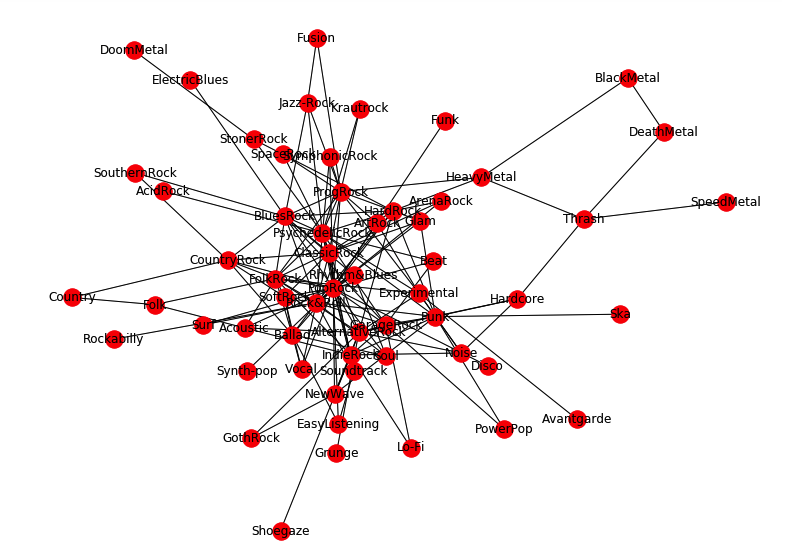

In [17]:
from IPython.display import Image
Image(filename='/Users/josephstern/Desktop/project_files/code-git/images/rock network.png',
      width=800, height=400)

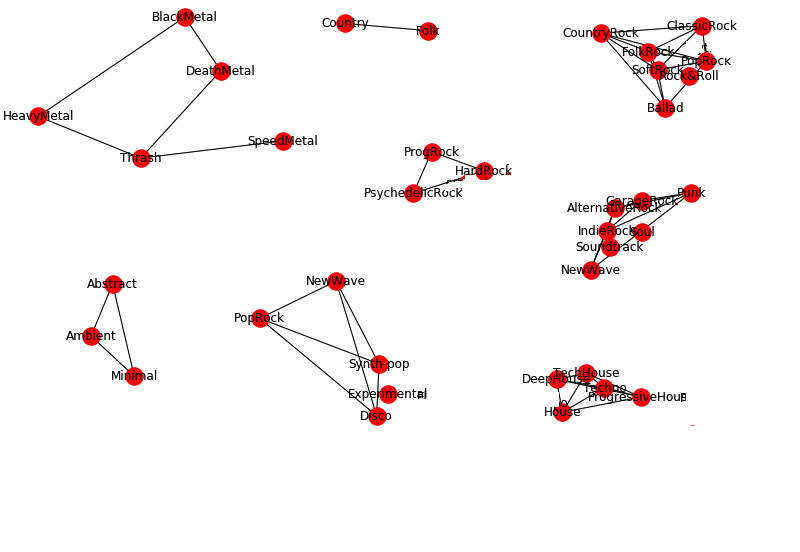

In [16]:
Image(filename='/Users/josephstern/Desktop/project_files/code-git/images/networks.png',
      width=800, height=400)

In [83]:
#with a carefully ordered if else statement I can split these sub-genres from their genres and create a hybrid field

test2 = pd.DataFrame(df7).join(binary_cols.drop(['Electronic'], axis=1))

community=[]
for i in test2.index:
    if test2['Rock'][i]==1:
        
        if test2['HeavyMetal'][i]==1:
            community.append('metal')
        elif test2['Country'][i]==1:
            community.append('country')
        elif test2['Experimental'][i]==1:
            community.append('experimental_rock')
        elif test2['PsychedelicRock'][i]==1:
            community.append('psychedelic_rock')
        elif test2['Punk'][i]==1:
            community.append('punk')
        elif test2['ClassicRock'][i]==1:
            community.append('classic_rock')
        else:
            community.append('other_rock')
            
    elif test2['Electronic'][i]==1:
        
        if test2['Synth-pop'][i]==1:
            community.append('synth_pop')
        elif test2['Minimal'][i]==1:
            community.append('minimal')
        elif test2['Trance'][i]==1:
            community.append('trance')
        elif test2['DrumnBass'][i]==1:
            community.append('drumnbass')
        elif test2['House'][i]==1 or test2['Techno'][i]==1:
            community.append('house/techno')
        else:
            community.append('other_electronic')
    else:
        community.append('other')

<a id="11"></a>
### Model Preparation

In [124]:
df7['community'] = community

df8 = df7.drop(columns=['artist','album','wh_ratio','ppl_want','ppl_have',
                      'seller','seller_rating','rated_sales','year',
                      'has_b_side','Electronic','log_price','label'])
df8.info()

df9 = pd.get_dummies(df8,columns=['vinyl_condition','sleeve_condition','ships_from',
                              'country_origin','community'],drop_first=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33414 entries, 0 to 33413
Data columns (total 11 columns):
pound_value         33414 non-null float64
rated               33414 non-null float64
weighted_ratio      33344 non-null float64
vinyl_condition     33414 non-null object
sleeve_condition    33414 non-null object
ships_from          33414 non-null object
url                 33414 non-null object
country_origin      33414 non-null object
track_no            33414 non-null float64
age                 33414 non-null int64
community           33414 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 2.8+ MB


In [126]:
binary_cols = pd.read_csv('../binary_cols.csv')

acceptable_formats = ['Vinyl','LP','Album','12"','45RPM','33⅓RPM',
                      '7"','Single','2×','Compilation','EP','Reissue',
                      'Stereo','Promo','Mono','Gatefold','Maxi-Single','3×']

df10 =df9.join(binary_cols[acceptable_formats])
len(df10)

df10.to_csv(('../df10.csv'))